In [84]:
from main import *
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import missingno as msno
import numpy as np
from datetime import datetime, timedelta
from shapely.geometry import MultiPoint
from concurrent.futures import ThreadPoolExecutor
from shapely.geometry import Point, MultiPoint, Polygon
import re
sns.set_style('whitegrid')

In [85]:
density_raw =pd.read_csv('density.csv')

density_raw['Date/Time'] = pd.to_datetime(density_raw['Date/Time'])

density_raw

,Unnamed: 0,Date/Time,MULTIPOINT
0,0,2022-06-01 00:00:00,NaN
1,1,2022-06-01 01:00:00,"MULTIPOINT ((-0.4045450401 -0.8040536104), (-0..."
2,2,2022-06-01 02:00:00,"MULTIPOINT ((-0.4542044599 -0.8557811118), (-0..."
3,3,2022-06-01 03:00:00,"MULTIPOINT ((-0.4044566834 -0.7817160046), (-0..."
4,4,2022-06-01 04:00:00,"MULTIPOINT ((-0.2658154075 -0.7027435313), (-0..."
...,...,...,...
716,716,2022-06-30 20:00:00,"MULTIPOINT ((-0.4126228945 -0.8110181005), (-0..."
717,717,2022-06-30 21:00:00,NaN
718,718,2022-06-30 22:00:00,"MULTIPOINT ((-0.3204977765 -0.710032636), (-0...."
719,719,2022-06-30 23:00:00,"MULTIPOINT ((-0.4081511538 -0.8052053781), (-0..."


In [87]:
# Pega o df do BIMTRA da API
df_bimtra_raw = request_api(endpoint='bimtra', inicial_date = '2022-06-01', final_date ='2022-06-30')

df_bimtra_raw[['dt_dep','dt_arr']] = df_bimtra_raw[['dt_dep','dt_arr']]/1000

df_bimtra_raw['deltaT'] = df_bimtra_raw['dt_arr']-df_bimtra_raw['dt_dep']

df_bimtra_raw['dt_dep'] = pd.to_datetime(df_bimtra_raw['dt_dep'], unit ='s')

df_bimtra_raw['hora_ref'] = df_bimtra_raw['dt_dep'].dt.floor('H')

df_bimtra_raw['hora_ref'] = df_bimtra_raw['dt_dep'].dt.floor('H')

df_bimtra = df_bimtra_raw.copy()

# Cálculo da distancia entre as coordenadas do aeroporto
df_bimtra['distance'] = df_bimtra.apply(calcular_distancia, axis=1)

df_bimtra


,flightid,origem,destino,dt_dep,dt_arr,deltaT,hora_ref
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,2022-06-01 00:44:57,1.654047e+09,2463.0,2022-06-01 00:00:00
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,2022-06-01 00:57:01,1.654047e+09,2152.0,2022-06-01 00:00:00
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,2022-06-01 00:26:52,1.654048e+09,4613.0,2022-06-01 00:00:00
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,2022-06-01 00:58:40,1.654048e+09,2581.0,2022-06-01 00:00:00
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,2022-06-01 01:00:38,1.654051e+09,5547.0,2022-06-01 01:00:00
...,...,...,...,...,...,...,...
22757,61eac72ffa7465ff8921a689e7651866,SBSP,SBSV,2022-06-30 11:50:16,1.656597e+09,6963.0,2022-06-30 11:00:00
22758,d7f60b0b401ee67b0b2e582c7de5f656,SBCF,SBKP,2022-06-30 22:44:55,1.656633e+09,3696.0,2022-06-30 22:00:00
22759,a87121f71eedc14aa5a18140eadd417c,SBRJ,SBBR,2022-06-30 01:33:05,1.656558e+09,5225.0,2022-06-30 01:00:00
22760,68cdc9ed30dff6b31f24ceca5bb01274,SBGR,SBFL,2022-06-30 00:36:22,1.656553e+09,3269.0,2022-06-30 00:00:00


In [147]:
data = df_bimtra.merge(density_raw, left_on='hora_ref', right_on='Date/Time', how='left')
data.head(10) 

,flightid,origem,destino,dt_dep,dt_arr,deltaT,hora_ref,distance,Unnamed: 0,Date/Time,MULTIPOINT
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,2022-06-01 00:44:57,1.654047e+09,2463.0,2022-06-01 00:00:00,406.747989,0,2022-06-01 00:00:00,NaN
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,2022-06-01 00:57:01,1.654047e+09,2152.0,2022-06-01 00:00:00,342.948013,0,2022-06-01 00:00:00,NaN
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,2022-06-01 00:26:52,1.654048e+09,4613.0,2022-06-01 00:00:00,928.188661,0,2022-06-01 00:00:00,NaN
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,2022-06-01 00:58:40,1.654048e+09,2581.0,2022-06-01 00:00:00,498.208232,0,2022-06-01 00:00:00,NaN
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,2022-06-01 01:00:38,1.654051e+09,5547.0,2022-06-01 01:00:00,1007.982120,1,2022-06-01 01:00:00,"MULTIPOINT ((-0.4045450401 -0.8040536104), (-0..."
...,...,...,...,...,...,...,...,...,...,...,...
22757,61eac72ffa7465ff8921a689e7651866,SBSP,SBSV,2022-06-30 11:50:16,1.656597e+09,6963.0,2022-06-30 11:00:00,1479.504420,707,2022-06-30 11:00:00,"MULTIPOINT ((-0.4375926042 -0.84818593), (-0.3..."
22758,d7f60b0b401ee67b0b2e582c7de5f656,SBCF,SBKP,2022-06-30 22:44:55,1.656633e+09,3696.0,2022-06-30 22:00:00,498.208232,718,2022-06-30 22:00:00,"MULTIPOINT ((-0.3204977765 -0.710032636), (-0...."
22759,a87121f71eedc14aa5a18140eadd417c,SBRJ,SBBR,2022-06-30 01:33:05,1.656558e+09,5225.0,2022-06-30 01:00:00,928.188661,697,2022-06-30 01:00:00,"MULTIPOINT ((-0.4125421964 -0.8332854308), (-0..."
22760,68cdc9ed30dff6b31f24ceca5bb01274,SBGR,SBFL,2022-06-30 00:36:22,1.656553e+09,3269.0,2022-06-30 00:00:00,515.566803,696,2022-06-30 00:00:00,NaN


<Axes: >

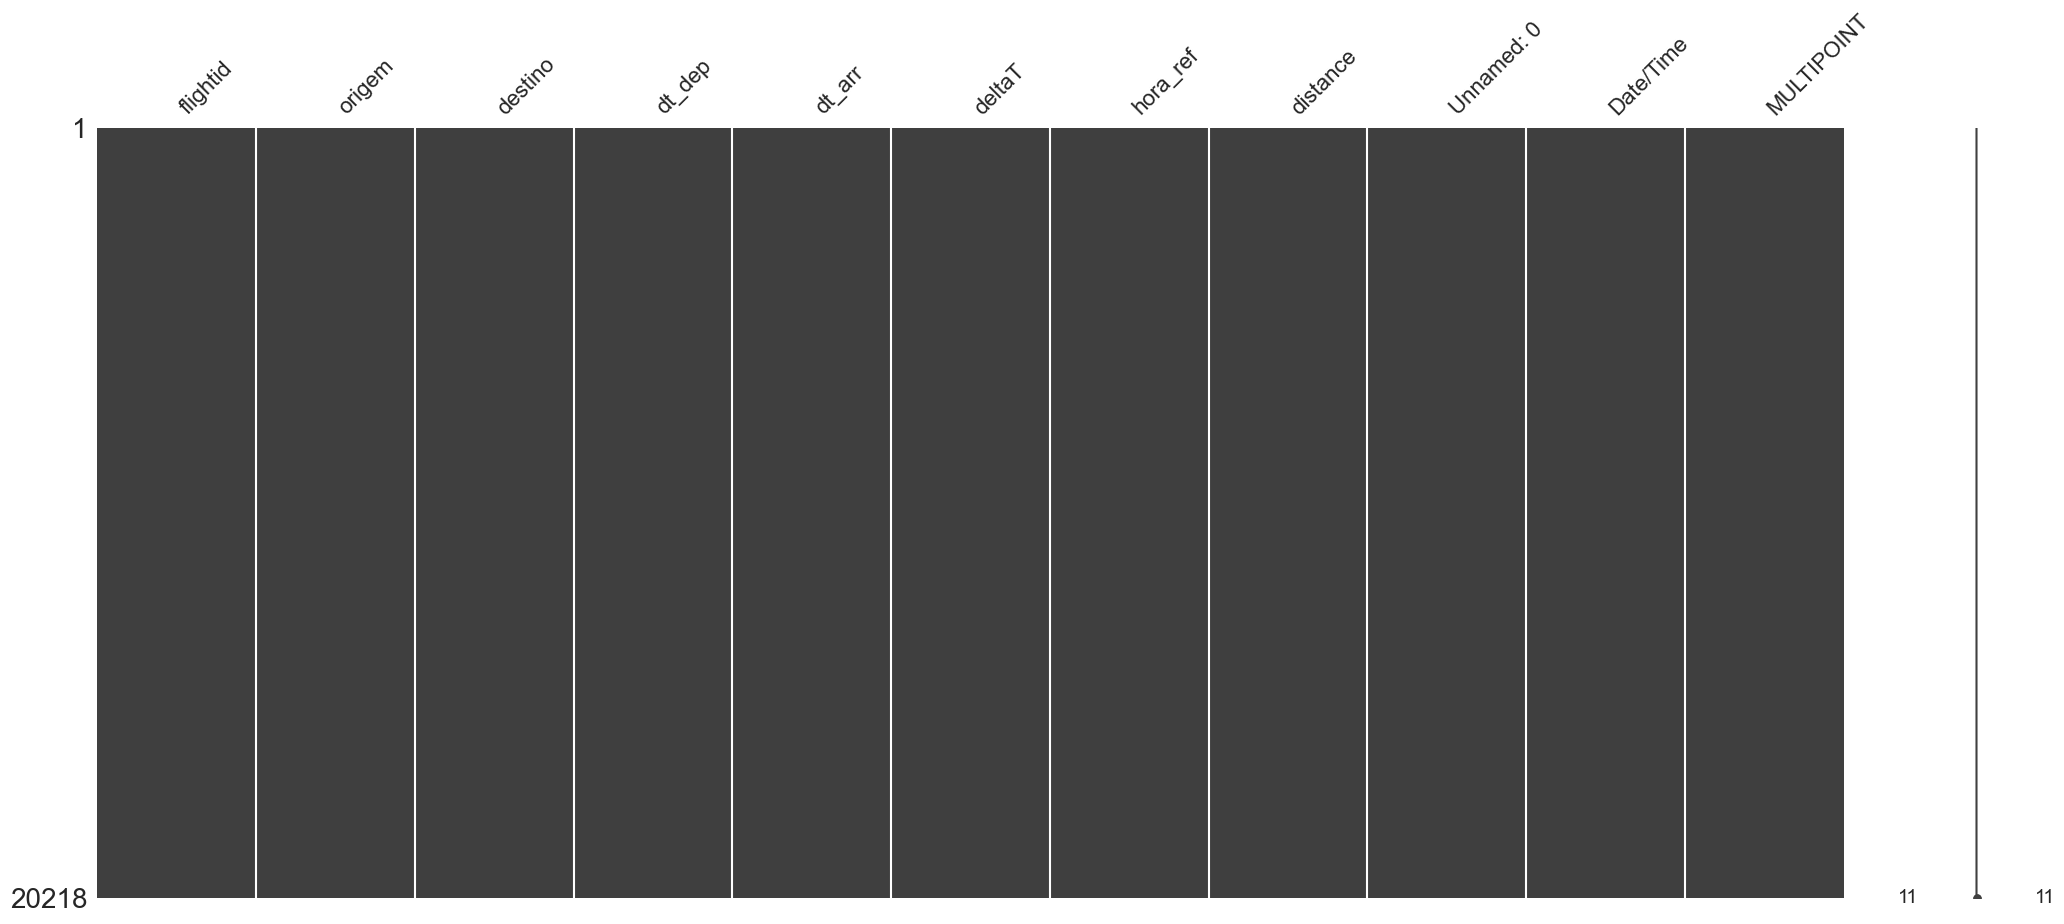

In [148]:
data= data.dropna().copy()
msno.matrix(data)

In [149]:
import math

# Função para montar o quadrado com base nas coordenadas de origem e destino em radianos
def build_square(origem, destino):
    # Converter as coordenadas dos aeroportos de graus decimais para radianos
    lat_rad_origem = math.radians(AEROPORTOS[origem][0])
    lon_rad_origem = math.radians(AEROPORTOS[origem][1])
    lat_rad_destino = math.radians(AEROPORTOS[destino][0])
    lon_rad_destino = math.radians(AEROPORTOS[destino][1])
    
    # Calcular as coordenadas do quadrado em radianos
    latitudes = [lat_rad_origem, lat_rad_destino]
    longitudes = [lon_rad_origem, lon_rad_destino]
    square_coords = (min(latitudes), max(latitudes), min(longitudes), max(longitudes))
    
    return square_coords

In [150]:
def count_points_inside_square(multipoint, square_coords):
    # Crie uma representação shapely do MULTIPOINT
    #multi_point = MultiPoint(multipoint)

    # Extraia as coordenadas do quadrado
    min_lat, max_lat, min_lon, max_lon = square_coords

    # Crie um retângulo shapely com base nas coordenadas do quadrado
    square = Polygon([(min_lon, min_lat), (max_lon, min_lat), (max_lon, max_lat), (min_lon, max_lat)])

    # Inicialize uma contagem de pontos dentro do quadrado
    count_inside_square = 0

    # Use regex para encontrar todas as coordenadas dentro dos parênteses
    coordenadas_str = re.findall(r'\((-?\d+\.\d+) (-?\d+\.\d+)\)', multipoint)
    
    # Crie uma lista de tuplas de coordenadas
    coordenadas = [(float(lat), float(lon)) for lat, lon in coordenadas_str]

    # Verifique se cada ponto do MULTIPOINT está dentro do quadrado
    for point in coordenadas:
        if (point[0] >= min_lat) & (point[0] <= max_lat) & (point[1] >= min_lon) & (point[1] >= max_lon):
            count_inside_square += 1

    return count_inside_square

In [157]:
def count_points_inside_square_test(multipoint, square_coords):

    # Extraia as coordenadas do quadrado
    min_lat, max_lat, min_lon, max_lon = square_coords

    # Crie um retângulo shapely com base nas coordenadas do quadrado
    square = Polygon([(min_lon, min_lat), (max_lon, min_lat), (max_lon, max_lat), (min_lon, max_lat)])

    # Inicialize uma contagem de pontos dentro do quadrado
    count_inside_square = 0
    
    # Use regex para encontrar todas as coordenadas dentro dos parênteses
    coordenadas_str = re.findall(r'\((-?\d+\.\d+) (-?\d+\.\d+)\)', multipoint)
    
    # Crie uma lista de tuplas de coordenadas
    coordenadas = [(float(lat), float(lon)) for lon, lat in coordenadas_str]

    # Verifique se cada ponto do MULTIPOINT está dentro do quadrado
    for point in coordenadas:
        if (point[0] >= min_lat) & (point[0] <= max_lat) & (point[1] >= min_lon) & (point[1] >= max_lon):
            count_inside_square += 1

    return count_inside_square

In [151]:
def square_area(square_coords):

    # Extraia as coordenadas do quadrado
    min_lat, max_lat, min_lon, max_lon = square_coords

    return (max_lat-min_lat)*(max_lon-min_lon)*100

In [152]:
data['square_coords'] = data.apply(lambda row: build_square(row['origem'], row['destino']), axis=1)

data['num_points_inside'] = data.apply(lambda row: count_points_inside_square(row['MULTIPOINT'], row['square_coords']), axis=1)

data['square_area'] = data.apply(lambda row: square_area( row['square_coords']), axis=1)


<Axes: >

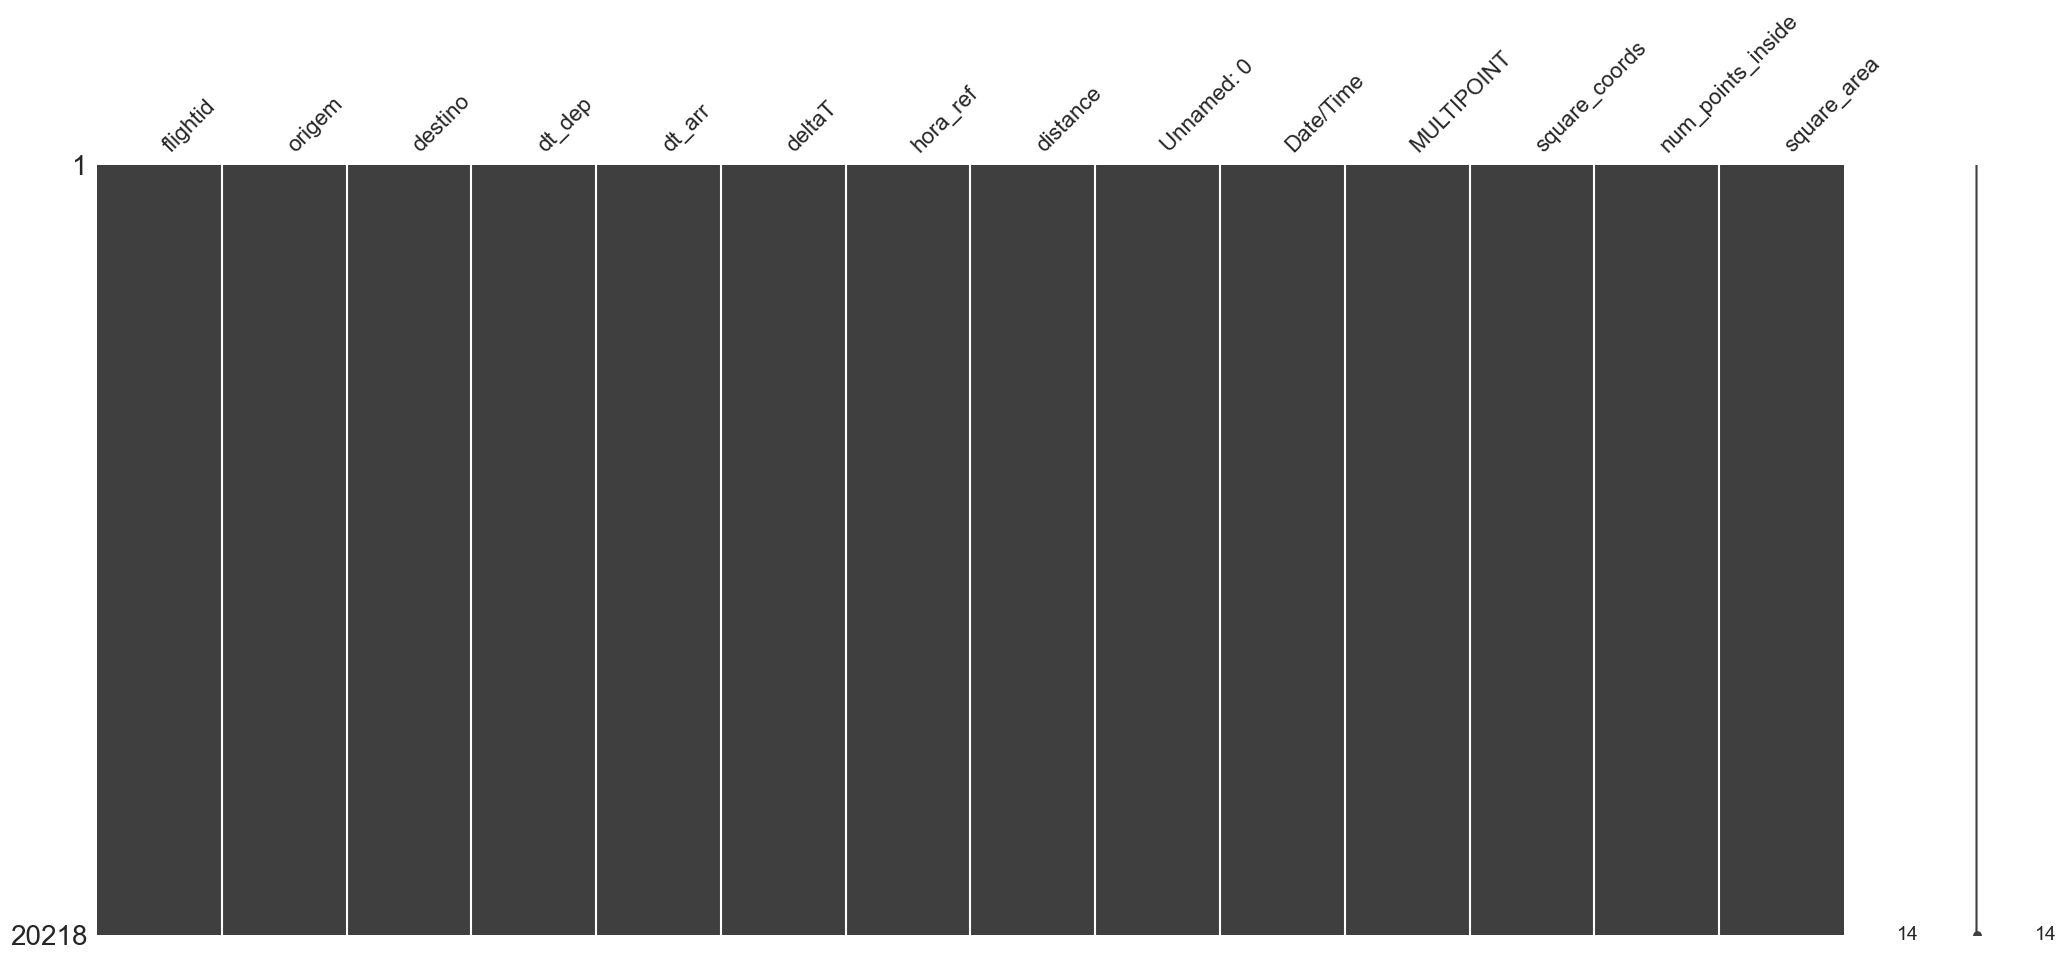

In [153]:
msno.matrix(data)

In [154]:
data['density']=data['num_points_inside']/data['square_area']
data

,flightid,origem,destino,dt_dep,dt_arr,deltaT,hora_ref,distance,Unnamed: 0,Date/Time,MULTIPOINT,square_coords,num_points_inside,square_area,density
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,2022-06-01 01:00:38,1.654051e+09,5547.0,2022-06-01 01:00:00,1007.982120,1,2022-06-01 01:00:00,"MULTIPOINT ((-0.4045450401 -0.8040536104), (-0...","(-0.4829483119900989, -0.34267969066581866, -0...",3,1.122232,2.673245
6,052050016538ab736a254313ef009a6b,SBRJ,SBCF,2022-06-01 09:20:04,1.654078e+09,3006.0,2022-06-01 09:00:00,373.769188,9,2022-06-01 09:00:00,"MULTIPOINT ((-0.4496633748 -0.8297270688), (-0...","(-0.3998671489366648, -0.34267969066581866, -0...",1,0.080368,12.442799
8,e93e3b8510854a55f195788019b5763b,SBGR,SBPA,2022-06-01 01:20:45,1.654051e+09,5020.0,2022-06-01 01:00:00,866.126835,1,2022-06-01 01:00:00,"MULTIPOINT ((-0.4045450401 -0.8040536104), (-0...","(-0.5234975465016832, -0.4089603143395553, -0....",6,0.939974,6.383154
9,2386fcd950814c8d343d93c4b51585d1,SBGR,SBPA,2022-06-01 01:13:59,1.654051e+09,5262.0,2022-06-01 01:00:00,866.126835,1,2022-06-01 01:00:00,"MULTIPOINT ((-0.4045450401 -0.8040536104), (-0...","(-0.5234975465016832, -0.4089603143395553, -0....",6,0.939974,6.383154
11,f738e67220fcd688fed028a6389891e2,SBKP,SBPA,2022-06-01 01:26:38,1.654052e+09,5084.0,2022-06-01 01:00:00,874.428439,1,2022-06-01 01:00:00,"MULTIPOINT ((-0.4045450401 -0.8040536104), (-0...","(-0.5234975465016832, -0.4015548823233434, -0....",13,0.859280,15.128941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22755,dc0fc4e303ebb7ac723e77ef29a2a696,SBPA,SBKP,2022-06-30 15:02:08,1.656606e+09,4566.0,2022-06-30 15:00:00,874.428439,711,2022-06-30 15:00:00,"MULTIPOINT ((-0.4118080167 -0.796450501), (-0....","(-0.5234975465016832, -0.4015548823233434, -0....",10,0.859280,11.637647
22756,78739ba51db62f57c791b62be502cbaa,SBFL,SBKP,2022-06-30 16:04:43,1.656608e+09,3258.0,2022-06-30 16:00:00,537.759826,712,2022-06-30 16:00:00,"MULTIPOINT ((-0.4091686112 -0.812114971), (-0....","(-0.4829483119900989, -0.4015548823233434, -0....",10,0.201410,49.649892
22757,61eac72ffa7465ff8921a689e7651866,SBSP,SBSV,2022-06-30 11:50:16,1.656597e+09,6963.0,2022-06-30 11:00:00,1479.504420,707,2022-06-30 11:00:00,"MULTIPOINT ((-0.4375926042 -0.84818593), (-0.3...","(-0.4123811596734642, -0.22538483828553976, -0...",0,2.717097,0.000000
22758,d7f60b0b401ee67b0b2e582c7de5f656,SBCF,SBKP,2022-06-30 22:44:55,1.656633e+09,3696.0,2022-06-30 22:00:00,498.208232,718,2022-06-30 22:00:00,"MULTIPOINT ((-0.3204977765 -0.710032636), (-0....","(-0.4015548823233434, -0.34267969066581866, -0...",2,0.325348,6.147265


In [144]:
data.columns

Index(['flightid', 'origem', 'destino', 'dt_dep', 'dt_arr', 'deltaT',
       'hora_ref', 'distance', 'Unnamed: 0', 'Date/Time', 'MULTIPOINT',
       'square_coords', 'num_points_inside', 'square_area', 'density'],
      dtype='object')

<Axes: xlabel='distance', ylabel='deltaT'>

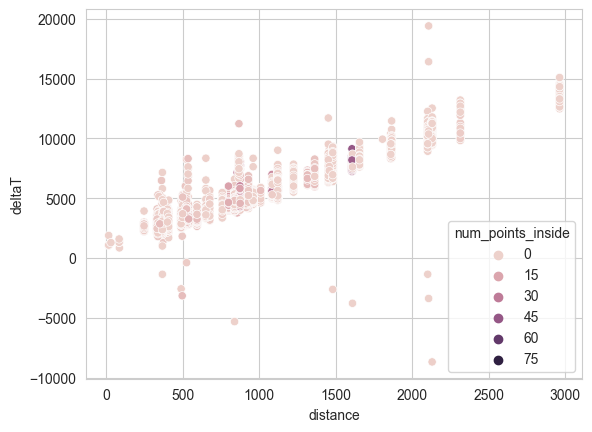

In [145]:
data_filtered =data[data['density']<=100]
sns.scatterplot(data=data_filtered, x='distance',y='deltaT', hue='num_points_inside')

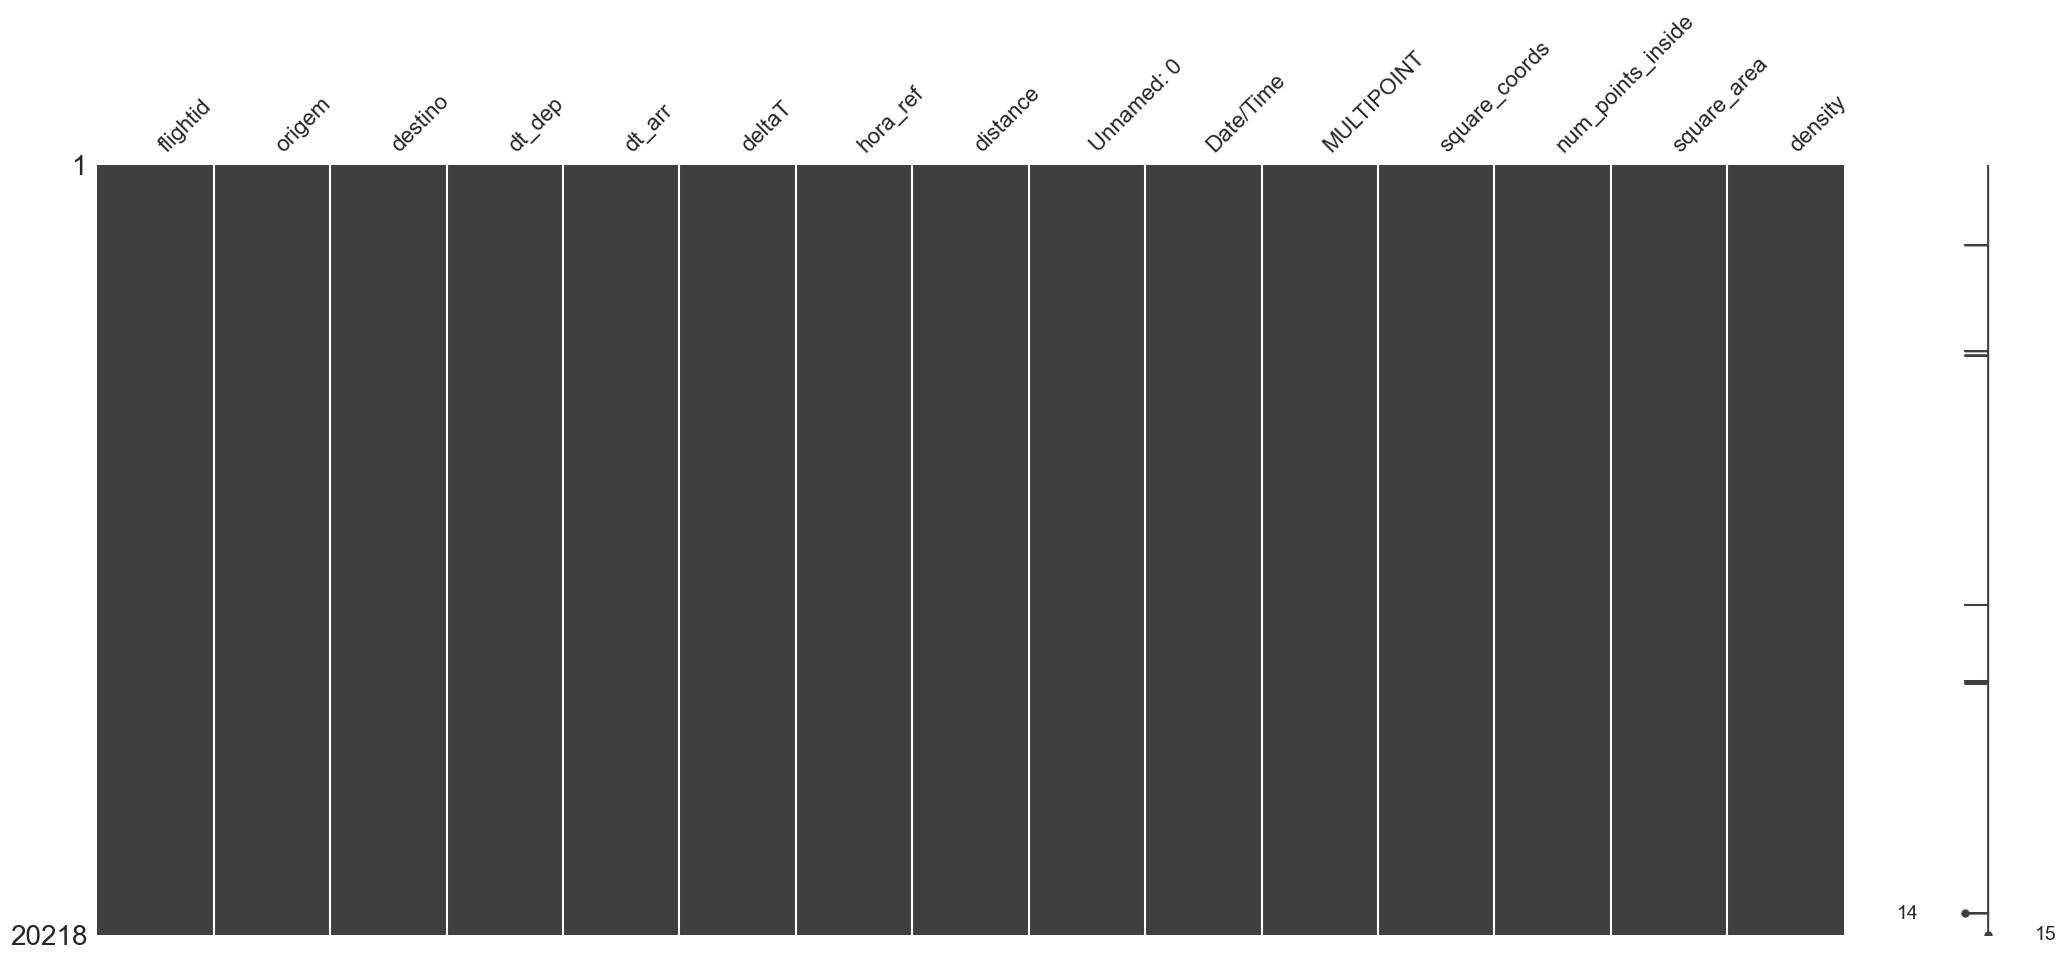

In [146]:
msno.matrix(data)
data.dropna(inplace=True)

In [113]:
# Importe as bibliotecas necessárias
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Suponha que você tenha um conjunto de dados (DataFrame) com colunas de recursos (X) e um alvo (y)
# ['flightid', 'origem', 'destino', 'dt_dep', 'dt_arr', 'deltaT',
#        'hora_ref', 'distance', 'Unnamed: 0', 'Date/Time', 'MULTIPOINT',
#        'square_coords', 'num_points_inside', 'square_area', 'density']
X =  data.drop(['flightid', 'origem', 'destino', 'dt_dep', 'dt_arr', 'deltaT',
       'hora_ref', 'Unnamed: 0', 'Date/Time', 'MULTIPOINT',
       'square_coords'], axis=1)
y =  data['deltaT']

# Divida o conjunto de dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crie um regressor Random Forest
rf_regressor = RandomForestRegressor(n_estimators=100)

# Treine o modelo no conjunto de treinamento
rf_regressor.fit(X_train, y_train)

# Faça previsões no conjunto de teste
y_pred = rf_regressor.predict(X_test)

# Avalie o desempenho do modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprima as métricas de desempenho
print(f"Erro Quadrático Médio (MSE): {mse}")
print(f"R-squared (R2): {r2}")

Erro Quadrático Médio (MSE): 205112.59483030904
R-squared (R2): 0.9615670974171256


<Axes: title={'center': 'Feature Importance de um Random Forest'}, xlabel='Importância das Características'>

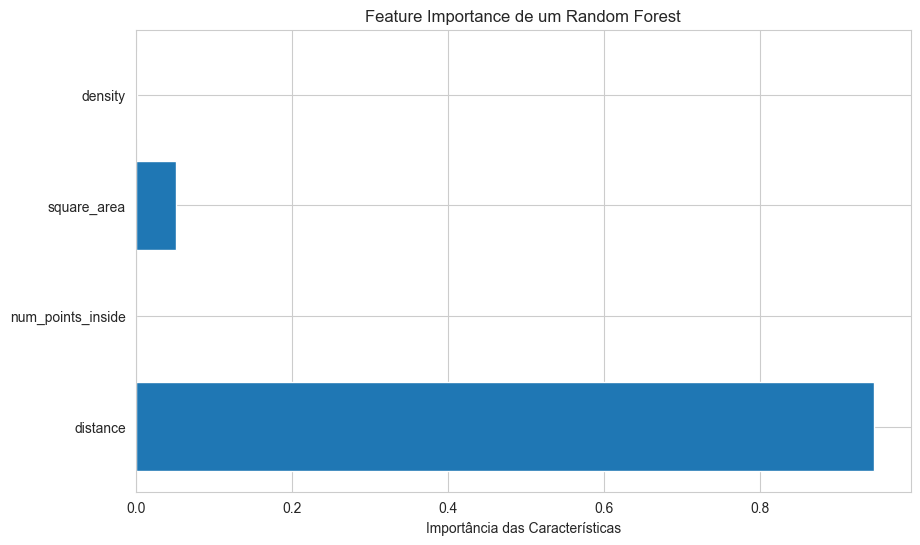

In [114]:
# Obtenha as importâncias das características do rf_regressoro
feature_importances = rf_regressor.feature_importances_
feature_names = X.columns

# Crie um gráfico de barras bonito para mostrar a importância das características
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances, align='center')
plt.yticks(np.arange(len(feature_importances)), feature_names)
plt.xlabel('Importância das Características')
plt.title('Feature Importance de um Random Forest')
plt.gca()

In [117]:
data_test = pd.read_csv('data\idsc_test.csv')
data_test.head(5)

,flightid,origem,destino,dt_dep,hora_ref,snapshot_radar,path,hora_esperas,esperas,aero_esperas,...,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr
0,7945735584a3297121c4f5ae0de8ecd1,SBKP,SBSV,2023-05-30 11:36:03.000,2023-05-30 11:00:00.000,MULTIPOINT ((-0.8807200448127578 -0.5148453155...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-30 10:00:00.000,0,SBSV,...,NaN,NaN,2023-05-30 11:00:00.000,METAR SBSV 301100Z 12009KT 9999 FEW023 28/21 Q...,SBSV,2023-05-30 12:00:00.000,0,SBSV,NaN,NaN
1,85cb958e8b9d583575cd9cb93e389226,SBFL,SBRJ,2023-05-19 08:26:06.000,2023-05-19 08:00:00.000,MULTIPOINT ((-0.8826266039383116 -0.4926305156...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 07:00:00.000,0,SBRJ,...,METAF SBRJ 190900Z 33004KT 9999 BKN033 ...,SBRJ,2023-05-19 08:00:00.000,METAR SBRJ 190800Z 02004KT 9999 FEW010 SCT040 ...,SBRJ,2023-05-19 09:00:00.000,0,SBRJ,NaN,NaN
2,2d4e8cd3947525a12ff16af520beefb9,SBCF,SBGR,2023-05-22 11:52:02.000,2023-05-22 11:00:00.000,MULTIPOINT ((-0.8972512464147154 -0.5215196550...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-22 10:00:00.000,0,SBGR,...,METAF SBGR 221200Z 04003KT CAVOK 19/09 Q1021=\n,SBGR,2023-05-22 11:00:00.000,METAR SBGR 221100Z 07006KT CAVOK 13/12 Q1022=,SBGR,2023-05-22 12:00:00.000,0,SBGR,NaN,NaN
3,24cf317a1494a016a018d9f5cd183639,SBFL,SBSP,2023-05-29 16:07:07.000,2023-05-29 16:00:00.000,MULTIPOINT ((-0.892972783728755 -0.51704889771...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-29 15:00:00.000,2,SBSP,...,METAF SBSP 291700Z 15010KT 9999 OVC033 ...,SBSP,2023-05-29 16:00:00.000,METAR SBSP 291600Z 12010KT 090V160 9999 SCT015...,SBSP,2023-05-29 17:00:00.000,0,SBSP,NaN,NaN
4,370babaf32dc82a6a64bf5b71a3434ed,SBCF,SBKP,2023-05-25 22:16:04.000,2023-05-25 22:00:00.000,MULTIPOINT ((-0.8970045369724385 -0.5240544927...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-25 21:00:00.000,0,SBKP,...,METAF SBKP 252300Z 08008KT CAVOK 21/12 Q1019=\n,SBKP,2023-05-25 22:00:00.000,METAR SBKP 252200Z 09004KT CAVOK 23/13 Q1020=,SBKP,2023-05-25 23:00:00.000,0,SBKP,NaN,NaN


In [118]:
data_test = data_test[['flightid','origem','destino','esperas','snapshot_radar']]

data_test['distance'] = data_test.apply(calcular_distancia, axis=1)

data_test


,flightid,origem,destino,esperas,snapshot_radar,distance
0,7945735584a3297121c4f5ae0de8ecd1,SBKP,SBSV,0,MULTIPOINT ((-0.8807200448127578 -0.5148453155...,1457.299674
1,85cb958e8b9d583575cd9cb93e389226,SBFL,SBRJ,0,MULTIPOINT ((-0.8826266039383116 -0.4926305156...,757.239533
2,2d4e8cd3947525a12ff16af520beefb9,SBCF,SBGR,0,MULTIPOINT ((-0.8972512464147154 -0.5215196550...,495.202334
3,24cf317a1494a016a018d9f5cd183639,SBFL,SBSP,2,MULTIPOINT ((-0.892972783728755 -0.51704889771...,488.073154
4,370babaf32dc82a6a64bf5b71a3434ed,SBCF,SBKP,0,MULTIPOINT ((-0.8970045369724385 -0.5240544927...,498.208232
...,...,...,...,...,...,...
95,6f6d576aafbd90e308a848a060395e9a,SBPA,SBGR,0,MULTIPOINT ((-0.8891070333352145 -0.5128856751...,866.126835
96,20055ed6ecea5e916923081fc3b049f7,SBCF,SBKP,0,MULTIPOINT ((-0.8887839089364267 -0.5156303040...,498.208232
97,c5e4e8d78906ae2b3218847cc9f045d9,SBSP,SBRJ,0,MULTIPOINT ((-0.8916331377478003 -0.5089690765...,365.627841
98,878ad3e9104c78f2945f6194c2d883ce,SBBR,SBSP,0,MULTIPOINT ((-0.8987280459174578 -0.5209708603...,872.709147


In [160]:
data_test['square_coords'] = data_test.apply(lambda row: build_square(row['origem'], row['destino']), axis=1)

data_test['num_points_inside'] = data_test.apply(lambda row: count_points_inside_square_test(row['snapshot_radar'], row['square_coords']), axis=1)

data_test['square_area'] = data_test.apply(lambda row: square_area( row['square_coords']), axis=1)

data_test['density']=data_test['num_points_inside']/data_test['square_area']
data_test

,flightid,origem,destino,esperas,snapshot_radar,distance,square_coords,num_points_inside,square_area,density
0,7945735584a3297121c4f5ae0de8ecd1,SBKP,SBSV,0,MULTIPOINT ((-0.8807200448127578 -0.5148453155...,1457.299674,"(-0.4015548823233434, -0.22538483828553976, -0...",0,2.706792,0.000000
1,85cb958e8b9d583575cd9cb93e389226,SBFL,SBRJ,0,MULTIPOINT ((-0.8826266039383116 -0.4926305156...,757.239533,"(-0.4829483119900989, -0.3998671489366648, -0....",0,0.781455,0.000000
2,2d4e8cd3947525a12ff16af520beefb9,SBCF,SBGR,0,MULTIPOINT ((-0.8972512464147154 -0.5215196550...,495.202334,"(-0.4089603143395553, -0.34267969066581866, -0...",8,0.289377,27.645569
3,24cf317a1494a016a018d9f5cd183639,SBFL,SBSP,2,MULTIPOINT ((-0.892972783728755 -0.51704889771...,488.073154,"(-0.4829483119900989, -0.4123811596734642, -0....",7,0.233505,29.978000
4,370babaf32dc82a6a64bf5b71a3434ed,SBCF,SBKP,0,MULTIPOINT ((-0.8970045369724385 -0.5240544927...,498.208232,"(-0.4015548823233434, -0.34267969066581866, -0...",4,0.325348,12.294530
...,...,...,...,...,...,...,...,...,...,...
95,6f6d576aafbd90e308a848a060395e9a,SBPA,SBGR,0,MULTIPOINT ((-0.8891070333352145 -0.5128856751...,866.126835,"(-0.5234975465016832, -0.4089603143395553, -0....",8,0.939974,8.510872
96,20055ed6ecea5e916923081fc3b049f7,SBCF,SBKP,0,MULTIPOINT ((-0.8887839089364267 -0.5156303040...,498.208232,"(-0.4015548823233434, -0.34267969066581866, -0...",4,0.325348,12.294530
97,c5e4e8d78906ae2b3218847cc9f045d9,SBSP,SBRJ,0,MULTIPOINT ((-0.8916331377478003 -0.5089690765...,365.627841,"(-0.4123811596734642, -0.3998671489366648, -0....",0,0.076297,0.000000
98,878ad3e9104c78f2945f6194c2d883ce,SBBR,SBSP,0,MULTIPOINT ((-0.8987280459174578 -0.5209708603...,872.709147,"(-0.4123811596734642, -0.2769802616329961, -0....",31,0.298802,103.747656


In [161]:
X_test =  data_test[['distance',	'num_points_inside',	'square_area','density']]

y_pred =  rf_regressor.predict(X_test)

In [162]:
data_submission = data_test[['flightid']].copy()
data_submission['solution'] = y_pred

data_submission = data_submission.rename(columns={'flightid':'ID'})

#data_submission['solution'] = data_submission['solution'].astype('int')
data_submission

,ID,solution
0,7945735584a3297121c4f5ae0de8ecd1,7303.062768
1,85cb958e8b9d583575cd9cb93e389226,4297.381995
2,2d4e8cd3947525a12ff16af520beefb9,3386.817780
3,24cf317a1494a016a018d9f5cd183639,3074.542501
4,370babaf32dc82a6a64bf5b71a3434ed,3136.199208
...,...,...
95,6f6d576aafbd90e308a848a060395e9a,4867.561954
96,20055ed6ecea5e916923081fc3b049f7,3136.199208
97,c5e4e8d78906ae2b3218847cc9f045d9,2689.140647
98,878ad3e9104c78f2945f6194c2d883ce,4992.661786


In [163]:
data_submission.to_csv('testenew.csv',index=False)